In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [5]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        embedding_trainable=True)

Number of inputs to dense layer: 156


# Train model 

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=2048,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 457s 1ms/step - loss: 1.1112e-04 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 0.9995


# Learning curves

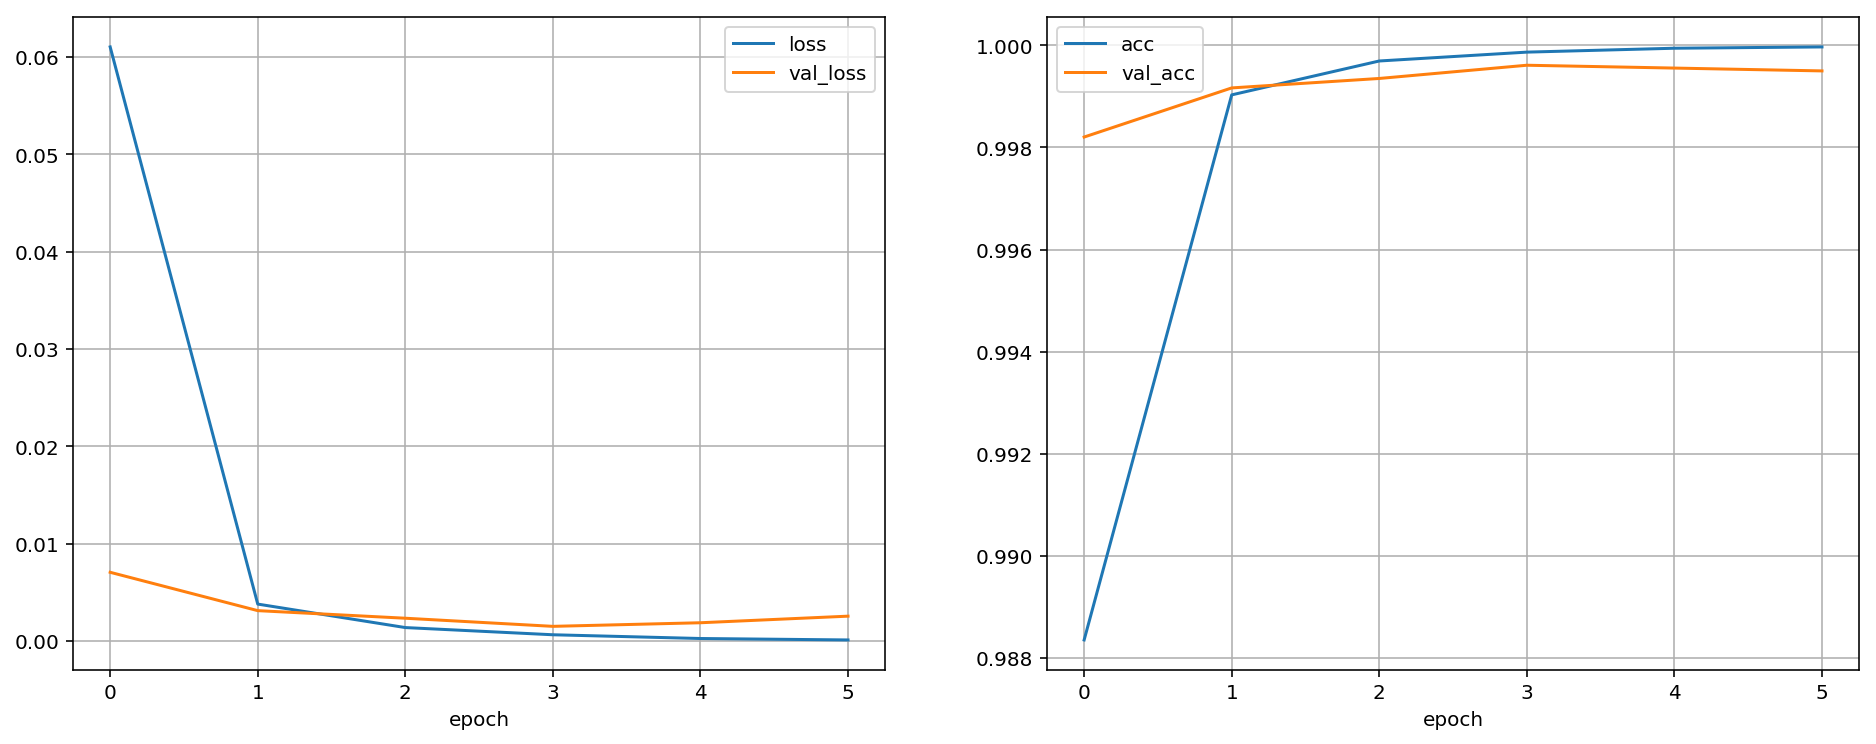

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [25]:
y_val_pred = model.predict(X_val, batch_size=4096)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.99      0.97      0.98       530

avg / total       1.00      1.00      1.00     54004

[[53468     6]
 [   18   512]]


In [26]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine

,id1,title,authors,venue,year,id2,title,authors,venue,year
1026,conf/vldb/AgrawalS94,fast algorithms for mining association rules in large databases,agrawal srikant,vldb,1994,3MzTom30SiMJ,fastalgorithmsformining association rules,rar srikant,of the vldb conference santiago chile september,0.0
9403,conf/sigmod/BratsbergT00,tutorial designing an ultra highly available dbms,nan,nan,2000,af50lhGnD8gJ,an ultra highly available dbms,so hvasshovd se bratsberg torbjoernsen,nan,0.0
11286,conf/vldb/ManegoldBK00,what happens during join dissecting cpu and memory optimization effects,manegold boncz kersten,vldb,2000,sZmrat79cF0J,what happens duringajoin dissectingcpuandmemoryoptimization effects,manegold pa boncz ml kersten,on very large data bases cairo egypt,0.0
11340,journals/vldb/PapadiasS94,qualitative representation of spatial knowledge in space,papadias sellis,vldb,1994,kEte3P_QB60J,qualitative representation ofspatial knowledge,dpt sellis,vldb journal,0.0
11699,conf/sigmod/ZhaoDNS98,simultaneous optimization and evaluation of multiple dimensional queries,zhao deshpande naughton shukla,sigmod conference,1998,6AK0GF7jAtsJ,pm deshpande jf naughton shukla simultaneous optimization and evaluation of multiple,zhao,acm sigmod,0.0
13493,conf/vldb/HellersteinNP95,generalized search trees for database systems,hellerstein naughton pfeffer,vldb,1995,SA4P684zTf4J,generalizedsearchtreesfordatabasesystems,jm hellerstein jf naughton,21st very large data bases,0.0
17181,journals/sigmod/CasatiDS00,vldb workshop on technologies in tes,nan,nan,2000,pJsnj7fi9LIJ,report on the vldb workshop on technologies for tes cairo egypt september 14 and 15,casati,sigmod record,2000.0
18381,conf/sigmod/LiYVGPUV98,capability based mediation in tsimmis,li yerneni vassalos papakonstantinou ullman valiveti,sigmod conference,1998,fOQEOEdh-mcJ,mediation in tsimmis,li yerneni,sigmod conference,0.0
23432,conf/sigmod/OlstonJW03,adaptive filters for continuous queries over distributed data streams,olston jiang widom,sigmod conference,2003,fW0CpIqoV7QJ,widomj 2003 adaptivefiltersforcontinuous queries over distributed data streams,jj olstonc,proceedings of acm sigmod,0.0
25979,conf/vldb/GardarinST96,calibrating the query optimizer cost model of an federated database system,gardarin sha tang,vldb,1996,RB2VKRwnXywJ,calibrating optimizer cost model of,gardarin sha zh tang,the vldb journal,0.0


# Save model and histories 

In [27]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-2t.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-2t')

# Test model 

In [28]:
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99963   0.99996   0.99979     53467
          1    0.99615   0.96283   0.97921       538

avg / total    0.99959   0.99959   0.99959     54005

[[53465     2]
 [   20   518]]
